# 目标检测和边界框

In [2]:
import torch
from d2l import torch as d2l

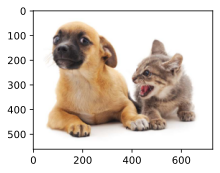

In [4]:
d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

In [8]:
# 从（左上，右下）转换到（中间，宽度，高度）
def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:,0], boxes[:, 1], boxes[:, 2], boxes[:,3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis = -1)
    return boxes

In [10]:
# 从（中间，宽度，高度）转换到（左上，右下）
def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [12]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [20]:
def bbox_to_rect(bbox, color):
    # 创建一个 matplotlib 的 Rectangle 对象
    # xy=(bbox[0], bbox[1]) 表示矩形的左上角坐标
    # width = bbox[2] - bbox[0] 表示矩形的宽度，即右下角x坐标减去左上角x坐标
    # height = bbox[3] - bbox[1] 表示矩形的高度，即右下角y坐标减去左上角y坐标
    # fill=False 表示矩形内部不填充颜色
    # edgecolor=color 表示矩形的边框颜色为指定的颜色
    # linewidth=2 表示矩形的边框线宽为2
    return d2l.plt.Rectangle(
        xy = (bbox[0], bbox[1]), width = bbox[2] - bbox[0], height = bbox[3] - bbox[1],
        fill = False, edgecolor = color, linewidth = 2)

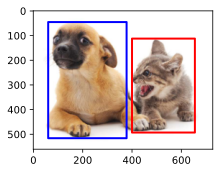

In [22]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# 目标检测数据集

In [1]:
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [19]:
# 定义一个函数，用于读取香蕉检测数据集 图像和标签
# 参数 is_train 是一个布尔值，默认为 True，表示是否读取训练集数据。如果为 True 则读取训练集，否则读取验证集
def read_data_bananas(is_train = True):
    # 调用 d2l 工具包中的 download_extract 函数，下载并解压 'banana-detection' 数据集
    # data_dir 是解压后数据集所在的目录路径
    data_dir = d2l.download_extract('banana-detection')
    
    # 根据 is_train 的值确定要读取的 CSV 文件路径
    # 如果 is_train 为 True，则读取训练集的标签文件 'banana_train/label.csv'
    # 如果 is_train 为 False，则读取验证集的标签文件 'banana_val/label.csv'
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    
    # 使用 pandas 库的 read_csv 函数读取 CSV 文件，将其存储为一个 DataFrame 对象
    csv_data = pd.read_csv(csv_fname)
    
    # 将 DataFrame 的索引设置为 'img_name' 列，方便后续根据图像名称进行索引操作
    csv_data = csv_data.set_index('img_name')
    
    # 初始化两个空列表，用于存储图像数据和对应的目标标签数据
    images, targets = [], []
    
    # 遍历 DataFrame 的每一行，img_name 是图像名称，target 是对应的标签信息
    for img_name, target in csv_data.iterrows():
        # 使用 torchvision.io.read_image 函数读取图像文件
        # 根据 is_train 的值确定图像所在的文件夹路径
        # 如果 is_train 为 True，则从 'bananas_train/images' 文件夹中读取图像
        # 如果 is_train 为 False，则从 'bananas_val/images' 文件夹中读取图像
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train'  if is_train else 'bananas_val', 'images', f'{img_name}')))
        
        # 将当前图像的标签信息转换为列表，并添加到 targets 列表中
        targets.append(list(target))
    
    # 将 targets 列表转换为 PyTorch 张量，并在第 1 维上增加一个维度（unsqueeze(1)）
    # 最后将所有目标标签的坐标值除以 256，进行归一化处理
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [21]:
# 读取香蕉检测数据集
# 定义一个自定义的数据集类 BananaDataset，继承自 torch.utils.data.Dataset
class BananaDataset(torch.utils.data.Dataset):
    # 类的初始化方法，在创建该类的实例时会自动调用
    def __init__(self, is_train):
        # 调用之前定义的 read_data_bananas 函数，根据 is_train 的值读取训练集或验证集数据
        # self.features 存储图像数据，self.labels 存储对应的标签数据
        self.features, self.labels = read_data_bananas(is_train)
        
        # 打印读取的样本数量信息
        # 如果 is_train 为 True，打印读取的训练样本数量；如果为 False，打印读取的验证样本数量
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
    
    # 该方法用于获取数据集中指定索引 idx 的样本
    def __getitem__(self, idx):
        # 返回索引为 idx 的图像数据（转换为 float 类型）和对应的标签数据
        return (self.features[idx].float(), self.labels[idx])
    
    # 该方法用于返回数据集的样本数量
    def __len__(self):
        # 返回图像数据的数量，即数据集的大小
        return len(self.features)

In [23]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    # 创建训练集的数据加载器
    # 首先，实例化一个 BananaDataset 类的对象，传入 is_train=True 表示创建训练集数据集
    # 然后，使用 torch.utils.data.DataLoader 创建数据加载器
    # batch_size 表示每个批次加载的数据样本数量
    # shuffle=True 表示在每个训练周期开始时对数据进行随机打乱，这样可以增加模型训练的随机性，有助于模型更好地学习数据特征
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True),
                            batch_size, shuffle=True)

    # 创建验证集的数据加载器
    # 同样，实例化一个 BananaDataset 类的对象，传入 is_train=False 表示创建验证集数据集
    # 这里没有设置 shuffle=True，因为在验证阶段不需要对数据进行打乱，按顺序加载数据进行模型评估即可
    val_iter = torch.utils.data.DataLoader(BananaDataset(is_train=False),
                          batch_size)

    # 返回训练集和验证集的数据加载器
    return train_iter, val_iter

In [25]:
# 图像的小批量的形状为（批量大小、通道数、高度、宽度）
# 定义批量大小为 32，即每次从数据集中加载 32 个样本
batch_size, edge_size = 32, 256

# 调用 load_data_bananas 函数来加载香蕉检测数据集
# 该函数返回训练集和验证集的数据加载器，这里只获取训练集的数据加载器 train_iter
train_iter, _ = load_data_bananas(batch_size)

# 使用 iter(train_iter) 将训练集的数据加载器转换为迭代器
# 然后使用 next() 函数从迭代器中取出一个批次的数据
# 这里得到的 batch 是一个包含图像数据和标签数据的元组
batch = next(iter(train_iter))

# 打印该批次中图像数据和标签数据的形状
# batch[0] 表示该批次中的图像数据
# batch[1] 表示该批次中的标签数据
print(batch[0].shape, batch[1].shape)

read 1000 training examples
read 100 validation examples
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


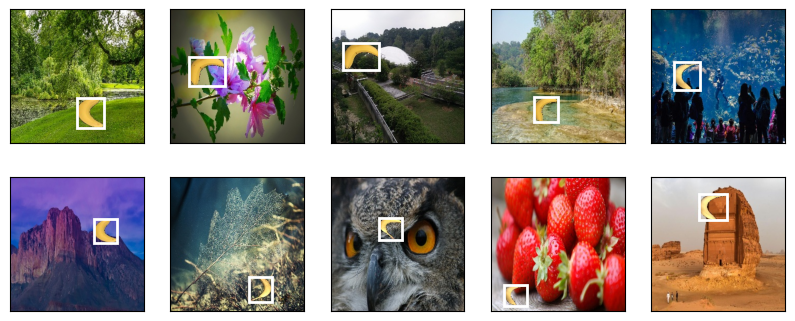

In [27]:
# 从当前批次的图像数据（batch[0]）中选取前 10 张图像
# 原始图像数据的形状通常为 (批量大小, 通道数, 高度, 宽度)，这里使用 permute(0, 2, 3, 1) 将通道维度移到最后，变为 (批量大小, 高度, 宽度, 通道数)
# 同时，将像素值从 [0, 255] 归一化到 [0, 1] 范围，因为后续的图像显示函数通常期望像素值在这个范围内
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255

# 使用 d2l 工具包中的 show_images 函数展示图像
# imgs 是要展示的图像列表
# 2 和 5 分别表示将图像排列成 2 行 5 列的网格
# scale=2 表示将图像的显示大小放大 2 倍
# axes 是返回的每个子图的坐标轴对象列表
axes = d2l.show_images(imgs, 2, 5, scale=2)

# 遍历每个子图的坐标轴对象和对应的前 10 个标签
# zip(axes, batch[1][0:10]) 将坐标轴对象和标签一一对应起来
for ax, label in zip(axes, batch[1][0:10]):
    # 对于每个子图，使用 d2l 工具包中的 show_bboxes 函数绘制边界框
    # ax 是当前子图的坐标轴对象
    # [label[0][1:5] * edge_size] 表示要绘制的边界框信息
    # 这里 label[0][1:5] 取出了边界框的坐标信息（通常索引 1 到 4 是边界框的坐标），乘以 edge_size 是将归一化的坐标还原到原始图像尺寸
    # colors=['w'] 表示边界框的颜色为白色
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])